In [1]:
import torch
import torchaudio
import pandas as pd
import numpy as np
import glob
import os
import re
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import torch.nn.functional as F
from torch import nn
import librosa
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps', index=0)

In [3]:
import json
import torchvision.transforms as transforms

train_mean = 2.5853811548103334
train_std = 48.60284136954955
normalize_t = transforms.Normalize(mean=train_mean, std=train_std)

class ReconstructedFakeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None, split="train", **transform_args):
        self.split = split
        self.data_dir = data_dir
        with open(f"{data_dir}/meta_data/{split}_reconstructed.json") as m:
            d = json.load(m)
            self.metadata = d["audios"]
        self.transform = transform
        self.precision = 0.01
        self.transform_args = transform_args
    def __len__(self):
        return len(self.metadata)
    def __getitem__(self, idx):
        m = self.metadata[idx]
        filepath = m["filepath"]
        label = m["label"]
        if not os.path.exists(filepath):
            print(f"ERROR - {filepath} not found")
        audio, sample_rate = torchaudio.load(filepath)
        if sample_rate != 32000:
            print(f"WARNING - audio {m["audio_id"]} resampled from {sample_rate} to 32khz")
            audio = torchaudio.functional.resample(audio, sample_rate, 32000)
            sample_rate = 32000
        onset, offset = (float(x) for x in m["onset_offset"].split("_"))
        segment = torch.zeros(int(10 / self.precision), device=device)
        segment[int(onset / self.precision): int(offset/self.precision)] = 1.0
        if self.transform:
            audio = self.transform(audio, sample_rate, **self.transform_args)
        # print(f"{audio_name} {audio_path} {label}")
        return (audio, torch.tensor(label, dtype=torch.float32), segment, {
            "onset": onset,
            "offset": offset,
            "audio_id": m["audio_id"]
        })
        # return audio.to(device), torch.tensor(label, dtype=torch.float32).to(device)
    
mel_spectrogram_32khz = T.MelSpectrogram(
        sample_rate=32000,
        n_fft=2048,
        hop_length=160,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=300,
        mel_scale="htk",
        f_min=0,
        f_max = 32000/2
    )

def transform(audio, sample_rate, n_fft=2048, hop_length=160, n_mels=300, win_length=None, normalize=True):
    if sample_rate == 32000:
        m = mel_spectrogram_32khz
    else:
        m = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        win_length=None,
        hop_length=160,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=300,
        mel_scale="htk",
        f_min=0,
        f_max = sample_rate/2
    )
    # s = spectrogram(audio)
    s = m(audio)
    s = F.pad(s, (0, 2000 - s.shape[2]))
    if normalize:
        s = normalize_t(s)
    return s

/opt/miniconda3/envs/deepfake-mamba/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (300) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


In [4]:
train_set = ReconstructedFakeSoundDataset("data/fakesound/FakeSound", transform=transform, split="train", normalize=True)

In [5]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram.cpu()), origin="lower", aspect="auto", interpolation="nearest")

(None, tensor(1., device='mps:0'))

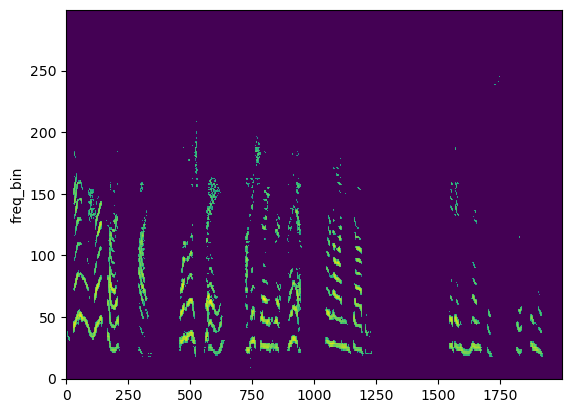

In [44]:
data = train_set[2]
(plot_spectrogram(data[0][0]), data[1])

In [5]:
class BaselineSegmentCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=8, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        ) # out is 256x8x60
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 8 * 61, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1)
        )
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=1),                    
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2),                  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=2),                  
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1000))
        )
        self.segmentation = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1000, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5)
            nn.Linear(2048, 1000),
            nn.ReLU())
    def forward(self, x):
        x = self.convolution(x)
        
        c = torch.flatten(x, -3)
        c = self.classifier(c)
        c = torch.sigmoid(c)
        
        s = self.upsample(x)
        s = torch.flatten(s, -3)
        s = self.segmentation(s)
        s = torch.sigmoid(s)
        
        return c, s

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2798748338.py, line 42)

In [6]:
model = BaselineSegmentCNN()
model.to(device)

BaselineSegmentCNN(
  (convolution): Sequential(
    (0): Conv2d(1, 8, kernel_size=(8, 8), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=124928, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1, bias=True)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2,

In [7]:
from tqdm import tqdm

def compute_mean_std(dataset):
    total_sum = 0.0
    total_squared_sum = 0.0
    total_count = 0
    
    for i in tqdm(range(len(dataset))):

        mel_spectrogram = dataset[i][0]
        
        mel_spectrogram_flat = mel_spectrogram.flatten()

        total_sum += mel_spectrogram_flat.sum().item()
        total_squared_sum += (mel_spectrogram_flat ** 2).sum().item()
        total_count += mel_spectrogram_flat.numel() 
        
    mean = total_sum / total_count
    std = (total_squared_sum / total_count - mean ** 2) ** 0.5
    
    return mean, std

# compute_mean_std(dataset)

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

In [ ]:
class_criterion = nn.BCELoss()
segmentation_criterion = nn.BCELoss()
alpha = 0.3 # class loss weight 
torch.autograd.set_detect_anomaly(True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.train()
writer = SummaryWriter()
for epoch in range(100):  # loop over the dataset multiple times
    print(f"Epoch {epoch}")
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # basic training loop
        inputs, labels, segments, _ = data
        inputs.to(device)
        labels.to(device)
        segments.to(device)
        optimizer.zero_grad()
        labels_, segments_ = model(inputs)
        class_loss = class_criterion(labels_.view(-1), labels)
        segmentation_loss = segmentation_criterion(segments_, segments)
        loss = alpha * class_loss + (1-alpha) * segmentation_loss
        loss.backward()
        optimizer.step()
        writer.add_scalar("Batch loss/train", loss.item(), epoch * len(train_loader) + i)
        running_loss += loss.item()
            
    writer.add_scalar("Loss/train", loss.item(), epoch)
    writer.add_scalar("Running loss/epoch", running_loss, epoch)
    writer.flush()
        
print('Finished Training')
writer.flush()

In [12]:
torch.save(model, 'checkpoint/baseline-segementation-cnn.pth')

In [15]:
def segmentation_metrics(pred, target):
    tp = (pred * target).sum().item()
    fp = ((pred == 1) & (target == 0)).sum().item()
    fn = ((pred == 0) & (target == 1)).sum().item()

    return tp, fp, fn

In [26]:
easy_dataset = ReconstructedFakeSoundDataset("data/fakesound/FakeSound", split='easy', transform=transform)
for split in ['easy', 'hard', 'zeroshot']:
    easy_dataset = ReconstructedFakeSoundDataset("data/fakesound/FakeSound", split=split, transform=transform)
    easy_loader = torch.utils.data.DataLoader(easy_dataset, batch_size=64, shuffle=True)
    model.eval()
    class_correct = 0
    n_samples = 0
    seg_tp = 0
    seg_fp = 0 
    seg_fn = 0
    with torch.no_grad():
        for j, vdata in enumerate(easy_loader, 0):
            vinputs, vclass, vseg, _ = vdata
            vclass_, vseg_ = model(vinputs)
            vclass_ = (vclass_.view(-1) > 0.5).float()
            vseg_ = (vseg_ > 0.5).float()
            class_correct += (vclass_ == vclass).sum()
            n_samples += vclass_.shape[0]
            tp, fp, fn = segmentation_metrics(vseg_, vseg)
            seg_tp += tp
            seg_fp += fp
            seg_fn += fn

    class_acc = class_correct/n_samples
    seg_prec = seg_tp / (seg_tp + seg_fp)
    seg_recall = seg_tp / (seg_tp + seg_fn)
    seg_f1 = 2 / ((1 / seg_prec) + (1/seg_recall))
    
    print(f"{split}: Class Accuracy = {class_correct} / {n_samples} = {class_acc.item()}, Segment Precision = {seg_prec}, Segment Recall = {seg_recall}. Segment F1 = {seg_f1}")
    print(f"{split} score = {alpha * class_acc + (1-alpha) * seg_f1}")

easy: Class Accuracy = 58 / 86 = 0.6744186282157898, Segment Precision = 0.33562731604023294, Segment Recall = 0.21501243499886954. Segment F1 = 0.2621098325639082
easy score = 0.3858024775981903
hard: Class Accuracy = 173 / 257 = 0.6731517314910889, Segment Precision = 0.2870586126545976, Segment Recall = 0.10261749911895685. Segment F1 = 0.15118831276108657
hard score = 0.3077773451805115
zeroshot: Class Accuracy = 165 / 257 = 0.6420233249664307, Segment Precision = 0.2036525090056128, Segment Recall = 0.08501188977479368. Segment F1 = 0.11995164433918043
zeroshot score = 0.27657315135002136


In [13]:
easy_dataset = ReconstructedFakeSoundDataset("data/fakesound/FakeSound", split='easy', transform=transform)
hard_dataset = ReconstructedFakeSoundDataset("data/fakesound/FakeSound", split='hard', transform=transform)
dev_dataset = torch.utils.data.ConcatDataset([easy_dataset, hard_dataset])

In [11]:
def evaluate_model(model, dataset):
    easy_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
    model.eval()
    class_correct = 0
    n_samples = 0
    seg_tp = 0
    seg_fp = 0 
    seg_fn = 0
    with torch.no_grad():
        for j, vdata in enumerate(easy_loader, 0):
            vinputs, vclass, vseg, _ = vdata
            vinputs = vinputs.to(device)
            vclass = vclass.to(device)
            vseg = vseg.to(device)
            vclass_, vseg_ = model(vinputs)
            vclass_ = (vclass_.view(-1) > 0.5).float()
            vseg_ = (vseg_ > 0.5).float()
            class_correct += (vclass_ == vclass).sum()
            n_samples += vclass_.shape[0]
            tp, fp, fn = segmentation_metrics(vseg_, vseg)
            seg_tp += tp
            seg_fp += fp
            seg_fn += fn

    class_acc = class_correct/n_samples
    seg_prec = seg_tp / (seg_tp + seg_fp)
    seg_recall = seg_tp / (seg_tp + seg_fn)
    seg_f1 = 2 / ((1 / seg_prec) + (1/seg_recall))
    score = alpha * class_acc + (1-alpha) * seg_f1
    print(f"Class Accuracy = {class_correct} / {n_samples} = {class_acc.item()}, Segment Precision = {seg_prec}, Segment Recall = {seg_recall}. Segment F1 = {seg_f1}")
    print(f"Score = {score}")

    return score, class_acc, seg_prec, seg_recall, seg_f1

In [29]:
evaluate_model(model, dev_dataset)

Class Accuracy = 231 / 343 = 0.6734693646430969, Segment Precision = 0.30341753343239225, Segment Recall = 0.12743703038018922. Segment F1 = 0.17948808100696154
Score = 0.3276824951171875


(tensor(0.3277, device='mps:0'),
 tensor(0.6735, device='mps:0'),
 0.30341753343239225,
 0.12743703038018922,
 0.17948808100696154)

In [37]:
test_dataset = ReconstructedFakeSoundDataset("data/fakesound/FakeSound", split='zeroshot', transform=transform)

In [38]:
evaluate_model(model, test_dataset)

WARNING - audio w-oSwpsXIuU_6.88_7.0 resampled from 16000 to 32khz
WARNING - audio kwbQqlfdRRE_0.04_9.96 resampled from 16000 to 32khz
WARNING - audio ZCLg2BD5r7o_1.36_1.64 resampled from 16000 to 32khz
WARNING - audio H7rd9bZtbgc_0.04_9.96 resampled from 16000 to 32khz
WARNING - audio LABWS8bgitY_8.76_9.0 resampled from 16000 to 32khz
WARNING - audio jD0zPQ-JbZI_5.8_6.0 resampled from 16000 to 32khz
WARNING - audio Ai6ynjVDKrY_4.8_6.96 resampled from 16000 to 32khz
WARNING - audio 4JbNc4q8hDY_5.56_5.68 resampled from 16000 to 32khz
WARNING - audio 3KYbrgBCc8c_6.76_6.96 resampled from 16000 to 32khz
WARNING - audio 5xLIpKIgRvc_7.6_7.88 resampled from 16000 to 32khz
WARNING - audio 8Twpl5_zhtk_7.6_9.64 resampled from 16000 to 32khz
WARNING - audio ZXE4ZEORCIw_0.04_9.96 resampled from 16000 to 32khz
WARNING - audio 1vG5Ej6bV4U_4.56_5.92 resampled from 16000 to 32khz
WARNING - audio 1Bp9yMJA7NE_9.64_9.84 resampled from 16000 to 32khz
WARNING - audio --RBwc_VFYA_7.08_7.12 resampled from 16

(tensor(0.2358, device='mps:0'),
 tensor(0.6342, device='mps:0'),
 0.1425363432218414,
 0.04217373059169115,
 0.06508891707369728)

In [5]:
class BaselineSegmentCNNSmall(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding='same'), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=5, stride=1, padding='same'), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same'), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=1, stride=1, padding='same'),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) # out is 32, 37, 250
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=32 * 37 * 250, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1)
        )

        self.segmentation = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(32 * 37 * 250, 1024),            
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1000),
            )
    def forward(self, x):
        x = self.convolution(x)
        x = torch.flatten(x, 1)
        
        c = self.classifier(x)
        c = torch.sigmoid(c)
        
        s = self.segmentation(x)
        s = torch.sigmoid(s)
        
        return c, s

In [6]:
model = BaselineSegmentCNNSmall()
model.to(device)

BaselineSegmentCNNSmall(
  (convolution): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=296000, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout

In [7]:
#del model

In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
class_criterion = nn.BCELoss()
segmentation_criterion = nn.BCELoss()
alpha = 0.3 # class loss weight 
torch.autograd.set_detect_anomaly(True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.train()
writer = SummaryWriter()
for epoch in range(20): 
    print(f"Epoch {epoch}")
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, segments, _ = data
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        segements = segments.to(device)
        labels_, segments_ = model(inputs)
        class_loss = class_criterion(labels_.view(-1), labels)
        segmentation_loss = segmentation_criterion(segments_, segments)
        loss = alpha * class_loss + (1-alpha) * segmentation_loss
        loss.backward()
        optimizer.step()
        writer.add_scalar("Batch loss/train", loss.item(), epoch * len(train_loader) + i)
        running_loss += loss.item()
        del inputs
        del labels
        del segments
            
    writer.add_scalar("Loss/train", loss.item(), epoch)
    writer.add_scalar("Running loss/epoch", running_loss, epoch)
    writer.flush()
        
print('Finished Training')
writer.flush()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Finished Training


In [9]:
torch.save(model, 'checkpoint/baseline-segementation-cnn-v2.pth')

In [16]:
evaluate_model(model, dev_dataset)

Class Accuracy = 232 / 343 = 0.6763848662376404, Segment Precision = 0.2212335446123842, Segment Recall = 0.09061634089717667. Segment F1 = 0.12857066959463048
Score = 0.2929149270057678


(tensor(0.2929, device='mps:0'),
 tensor(0.6764, device='mps:0'),
 0.2212335446123842,
 0.09061634089717667,
 0.12857066959463048)

In [17]:
test_dataset = ReconstructedFakeSoundDataset("data/fakesound/FakeSound", split='zeroshot', transform=transform)
evaluate_model(model, test_dataset)


WARNING - audio ZXE4ZEORCIw_0.04_9.96 resampled from 16000 to 32khz
WARNING - audio a1vjSQEmKM0_6.68_6.84 resampled from 16000 to 32khz
WARNING - audio 5OrXB62YfqY_0.04_9.96 resampled from 16000 to 32khz
WARNING - audio 76oNHURGTGk_9.24_9.56 resampled from 16000 to 32khz
WARNING - audio jD0zPQ-JbZI_5.8_6.0 resampled from 16000 to 32khz
WARNING - audio OCWJtB_PqwA_0.08_4.12 resampled from 16000 to 32khz
WARNING - audio 62O6MLZZLb8_8.12_8.6 resampled from 16000 to 32khz
WARNING - audio 3x_0EZFENtE_4.4_4.68 resampled from 16000 to 32khz
WARNING - audio --RBwc_VFYA_7.08_7.12 resampled from 16000 to 32khz
WARNING - audio _7Mztn2UG_I_8.88_9.4 resampled from 16000 to 32khz
WARNING - audio -HnhPxiYLLU_2.0_2.28 resampled from 16000 to 32khz
WARNING - audio 4lyYXg418jg_1.56_1.6 resampled from 16000 to 32khz
WARNING - audio -K0wP_zCTvA_4.4_4.48 resampled from 16000 to 32khz
WARNING - audio 86TRX2HBRU0_4.08_4.32 resampled from 16000 to 32khz
WARNING - audio 5cJZ-0kXxE8_8.4_8.56 resampled from 1600

(tensor(0.2526, device='mps:0'),
 tensor(0.6381, device='mps:0'),
 0.14779350541215652,
 0.06207161840816897,
 0.08742550362015465)